In [59]:
import pandas as pd
from modalities.utils.profilers.profile_logs_analyzers import ProfileLogsAnalyzer
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

In [64]:
log_dirs = list(Path("/leonardo_scratch/fast/EUHPC_D21_101/max_lue/repositories/working/modalities/tutorials/scaling_up/experiments/2025-06-01__18-59-55").glob("*"))
log_dirs

[PosixPath('/leonardo_scratch/fast/EUHPC_D21_101/max_lue/repositories/working/modalities/tutorials/scaling_up/experiments/2025-06-01__18-59-55/num_ranks_32'),
 PosixPath('/leonardo_scratch/fast/EUHPC_D21_101/max_lue/repositories/working/modalities/tutorials/scaling_up/experiments/2025-06-01__18-59-55/num_ranks_8'),
 PosixPath('/leonardo_scratch/fast/EUHPC_D21_101/max_lue/repositories/working/modalities/tutorials/scaling_up/experiments/2025-06-01__18-59-55/num_ranks_128'),
 PosixPath('/leonardo_scratch/fast/EUHPC_D21_101/max_lue/repositories/working/modalities/tutorials/scaling_up/experiments/2025-06-01__18-59-55/num_ranks_4'),
 PosixPath('/leonardo_scratch/fast/EUHPC_D21_101/max_lue/repositories/working/modalities/tutorials/scaling_up/experiments/2025-06-01__18-59-55/num_ranks_64'),
 PosixPath('/leonardo_scratch/fast/EUHPC_D21_101/max_lue/repositories/working/modalities/tutorials/scaling_up/experiments/2025-06-01__18-59-55/num_ranks_16')]

In [65]:
grid_search_dims = ["batch_size", "sequence_length", "num_ranks"]

In [98]:
results_list = []
for log_dir in log_dirs:
    results = ProfileLogsAnalyzer.load_profiling_logs(log_dir)
    df = ProfileLogsAnalyzer.to_pandas_df(results)
    df["total_step_time"] = df["forward_time"] + df["backward_time"] + df["step_time"]
    df["token_throughput"] = df["sequence_length"]*df["batch_size"] / df["total_step_time"]
    df["sample_throughput"] = df["token_throughput"] / (df["sequence_length"])
    df.sort_values(by=["total_step_time"], inplace=True, ascending=True)
    df["error"] = df["error"].apply(lambda x: x[:20])
    results_list.append(df)

combined_df = pd.concat(results_list, ignore_index=True)
combined_df

,batch_size,sequence_length,vocab_size,local_rank,global_rank,num_ranks,hostname,peak_memory,forward_time,backward_time,step_time,error,total_step_time,token_throughput,sample_throughput
0,3,4096,50304,0,24,32,lrdn1987.leonardo.local,-1.000000,-1.000000,-1.000000,-1.000000,CUDA out of memory.,-3.000000,-4096.000000,-1.000000
1,3,8192,50304,0,0,32,lrdn1901.leonardo.local,-1.000000,-1.000000,-1.000000,-1.000000,CUDA out of memory.,-3.000000,-8192.000000,-1.000000
2,3,4096,50304,2,2,32,lrdn1901.leonardo.local,-1.000000,-1.000000,-1.000000,-1.000000,CUDA out of memory.,-3.000000,-4096.000000,-1.000000
3,3,8192,50304,3,19,32,lrdn1957.leonardo.local,-1.000000,-1.000000,-1.000000,-1.000000,CUDA out of memory.,-3.000000,-8192.000000,-1.000000
4,2,8192,50304,3,7,32,lrdn1923.leonardo.local,-1.000000,-1.000000,-1.000000,-1.000000,CUDA out of memory.,-3.000000,-5461.333333,-0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2263,2,4096,50304,2,14,16,lrdn2041.leonardo.local,51450.241699,0.060622,1.102449,0.186134,,1.349205,6071.723172,1.482354
2264,2,4096,50304,0,0,16,lrdn2019.leonardo.local,51450.241699,0.057353,1.105681,0.186309,,1.349343,6071.102475,1.482203
2265,2,4096,50304,2,6,16,lrdn2024.leonardo.local,51450.241699,0.060264,1.102339,0.186759,,1.349363,6071.014245,1.482181
2266,2,4096,50304,1,9,16,lrdn2033.leonardo.local,51450.241699,0.057705,1.106475,0.186701,,1.350881,6064.192195,1.480516


In [99]:
combined_df = combined_df[combined_df["error"] == ""]
combined_df

,batch_size,sequence_length,vocab_size,local_rank,global_rank,num_ranks,hostname,peak_memory,forward_time,backward_time,step_time,error,total_step_time,token_throughput,sample_throughput
96,1,2048,50304,2,14,32,lrdn1941.leonardo.local,15761.099609,0.062256,0.588116,0.054312,,0.704683,2906.270139,1.419077
97,1,2048,50304,1,17,32,lrdn1957.leonardo.local,15761.099609,0.063452,0.587279,0.054079,,0.704811,2905.742945,1.418820
98,1,2048,50304,2,18,32,lrdn1957.leonardo.local,15761.099609,0.063044,0.587726,0.054051,,0.704821,2905.703689,1.418801
99,1,2048,50304,3,19,32,lrdn1957.leonardo.local,15761.099609,0.064689,0.586087,0.054086,,0.704862,2905.534455,1.418718
100,1,2048,50304,0,16,32,lrdn1957.leonardo.local,15761.099609,0.062295,0.588419,0.054149,,0.704863,2905.530831,1.418716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2263,2,4096,50304,2,14,16,lrdn2041.leonardo.local,51450.241699,0.060622,1.102449,0.186134,,1.349205,6071.723172,1.482354
2264,2,4096,50304,0,0,16,lrdn2019.leonardo.local,51450.241699,0.057353,1.105681,0.186309,,1.349343,6071.102475,1.482203
2265,2,4096,50304,2,6,16,lrdn2024.leonardo.local,51450.241699,0.060264,1.102339,0.186759,,1.349363,6071.014245,1.482181
2266,2,4096,50304,1,9,16,lrdn2033.leonardo.local,51450.241699,0.057705,1.106475,0.186701,,1.350881,6064.192195,1.480516


In [107]:
# aggregate over the ranks of each experiment
agg_df = combined_df.groupby(grid_search_dims).agg({
        "token_throughput": "sum",
        "sample_throughput": "sum",
        "peak_memory": "max"
    }).reset_index()

agg_df.head()

,batch_size,sequence_length,num_ranks,token_throughput,sample_throughput,peak_memory
0,1,2048,4,15450.465429,7.544173,35296.321289
1,1,2048,8,26673.647026,13.024242,23768.926758
2,1,2048,16,38688.335005,18.890789,18431.541992
3,1,2048,32,92871.497194,45.347411,15761.099609
4,1,2048,64,149792.799173,73.141015,14428.253906


In [102]:
# Group by 'num_ranks' and 'sequence_length' and keep row with max 'token_throughput'
filtered_df = agg_df.loc[agg_df.groupby(['num_ranks', 'sequence_length'])['token_throughput'].idxmax()]

# Optional: reset the index if you want a clean DataFrame
filtered_df = filtered_df.reset_index(drop=True)
filtered_df

,batch_size,sequence_length,num_ranks,token_throughput,sample_throughput,peak_memory
0,2,2048,4,18749.532069,9.155045,44982.962402
1,1,4096,4,18082.290713,4.414622,45014.962402
2,3,2048,8,49480.479034,24.160390,45381.200684
3,1,4096,8,43888.987497,10.715085,34438.700684
4,1,8192,8,25915.286031,3.163487,56797.747559
5,3,2048,16,102874.078744,50.231484,40095.819824
6,2,4096,16,97178.658657,23.725258,51450.241699
7,1,8192,16,98019.025533,11.965213,51513.366699
8,3,2048,32,225074.543546,109.899679,37486.504395
9,2,4096,32,225623.385479,55.083834,48809.051270


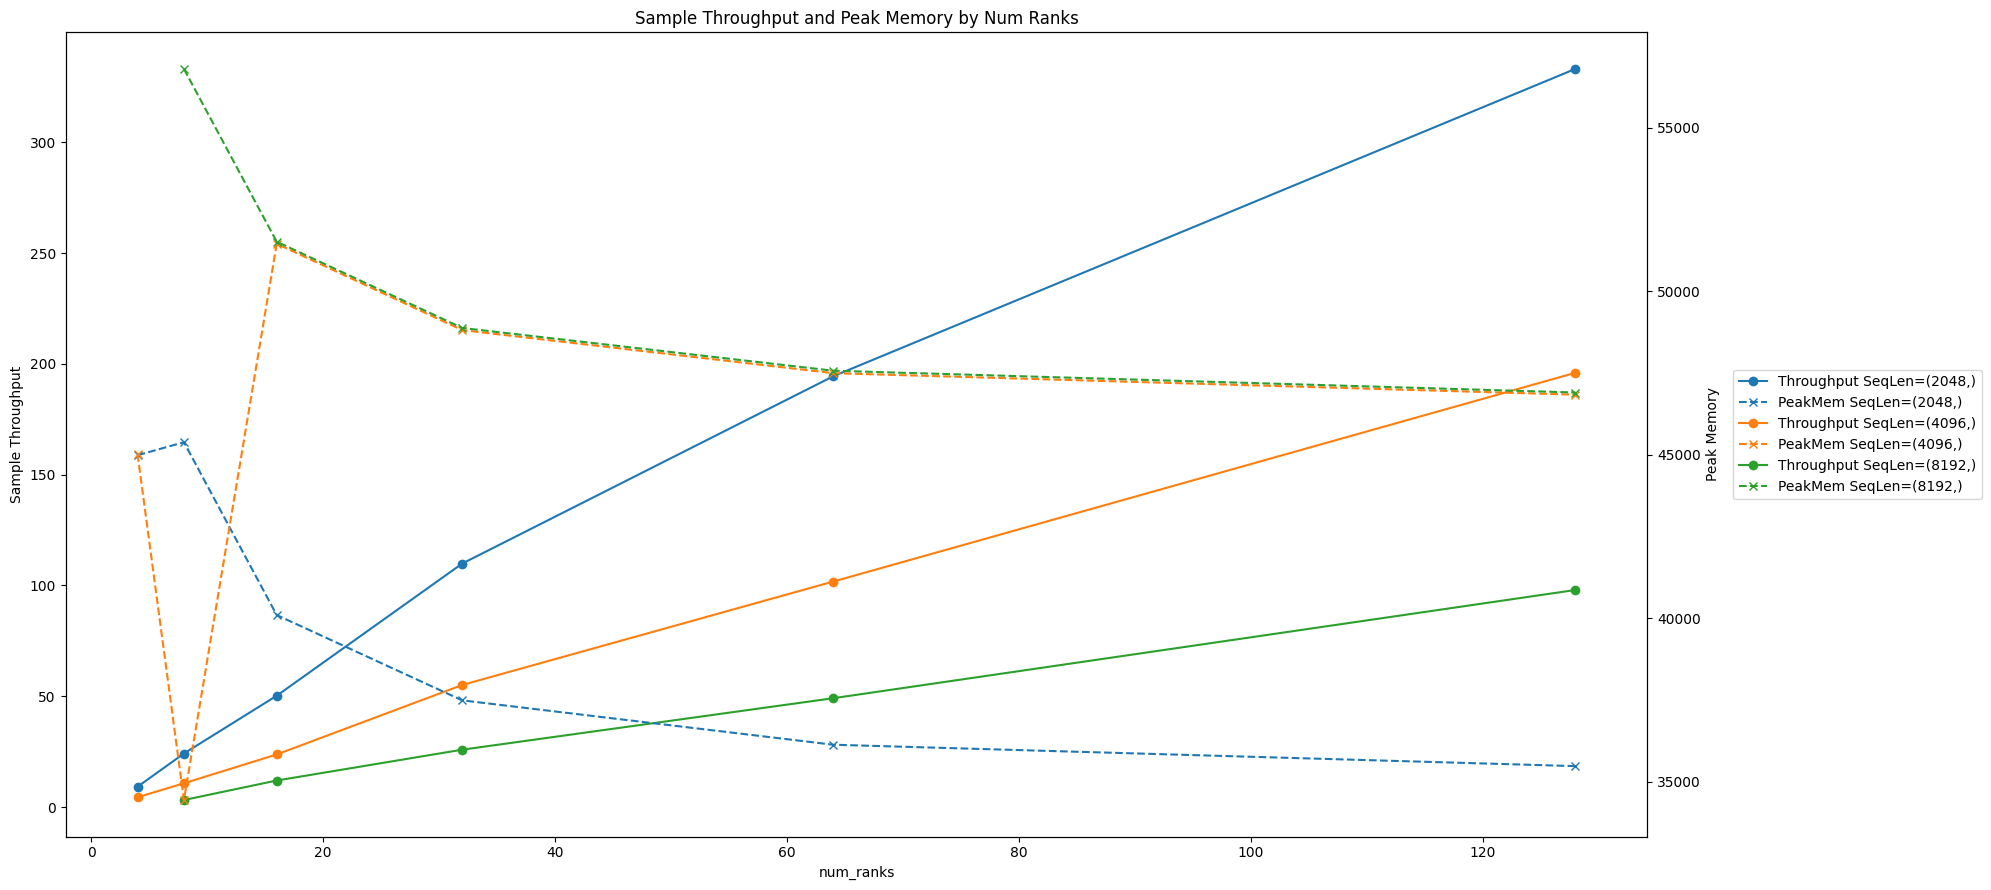

In [103]:

# Plot token throughput
fig, ax1 = plt.subplots(figsize=(20, 9))
ax2 = ax1.twinx()

# Store all line handles and labels for a single legend later
lines = []
labels = []

# Group by sequence_length and batch_size
for (seq_len), group in filtered_df.groupby(['sequence_length']):
    label = f'SeqLen={seq_len}'
    
    group_sorted = group.sort_values('num_ranks')
    
    # Plot sample_throughput
    l1, = ax1.plot(group_sorted['num_ranks'], group_sorted['sample_throughput'],
                   marker='o', label=f'Sample Throughput {label}')
    lines.append(l1)
    labels.append(f'Throughput {label}')
    
    # Plot peak_memory
    l2, = ax2.plot(group_sorted['num_ranks'], group_sorted['peak_memory'],
                   marker='x', linestyle='--', label=f'PeakMem {label}')
    lines.append(l2)
    labels.append(f'PeakMem {label}')

# Labels and titles
ax1.set_xlabel('num_ranks')
ax1.set_ylabel('Sample Throughput')
ax2.set_ylabel('Peak Memory')
ax1.set_title('Sample Throughput and Peak Memory by Num Ranks')

# Single combined legend
ax1.legend(lines, labels, loc='center left', bbox_to_anchor=(1.05, 0.5))

plt.tight_layout()
plt.show()



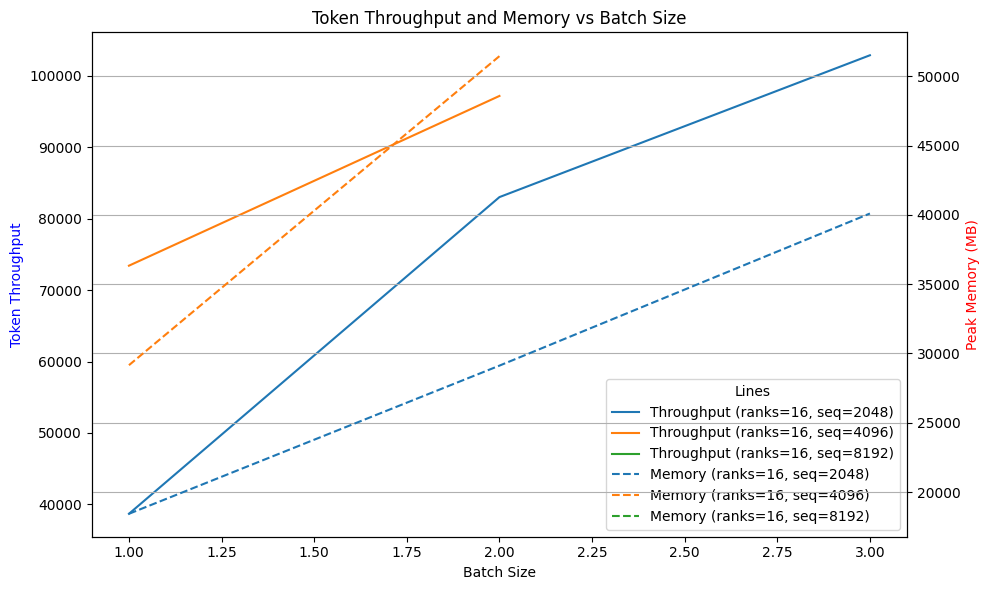

In [106]:
# Clean data
df = df[(df["token_throughput"] > 0) & (df["peak_memory"] > 0)]

# Start figure
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Color cycle for consistency across axes
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, ((num_ranks, seq_len), group) in enumerate(df.groupby(["num_ranks", "sequence_length"])):
    color = colors[i % len(colors)]
    
    # Aggregate by batch_size
    grouped = group.groupby("batch_size").agg({
        "token_throughput": "sum",
        "peak_memory": "max"
    })

    ax1.plot(grouped.index, grouped["token_throughput"], label=f"Throughput (ranks={num_ranks}, seq={seq_len})", color=color, linestyle='-')
    ax2.plot(grouped.index, grouped["peak_memory"], label=f"Memory (ranks={num_ranks}, seq={seq_len})", color=color, linestyle='--')

# Labels and legends
ax1.set_xlabel("Batch Size")
ax1.set_ylabel("Token Throughput", color='blue')
ax2.set_ylabel("Peak Memory (MB)", color='red')

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="lower right", title="Lines")

plt.title("Token Throughput and Memory vs Batch Size")
plt.grid(True)
plt.tight_layout()
plt.show()